In [103]:
import json
import re
import sys
import pandas as pd
import numpy as np


In [139]:
df_train = pd.read_csv('../storage/train_data/train-250315-01.csv')
df_train.head()

,공고번호,주택명,공급지역코드,공급지역명,공급위치우편번호,공급위치,공급규모,모집공고일,청약접수시작일,청약접수종료일,...,공급금액(최고가 기준),위도,경도,행정동코드,법정동코드,시도,시군구,읍면동1,읍면동2,전용면적당 공급금액(최고가기준)
0,2025000043,부천 JY 포에시아,410,경기,14636,경기도 부천시 원미구 신흥로 20,55,2025-02-28,2025-03-10,2025-03-11,...,377000000.0,37.485377,126.776922,4.119252e+09,4.119210e+09,경기,부천시 원미구,심곡2동,심곡동,8.767442e+06
1,2025000043,부천 JY 포에시아,410,경기,14636,경기도 부천시 원미구 신흥로 20,55,2025-02-28,2025-03-10,2025-03-11,...,377000000.0,37.485377,126.776922,4.119252e+09,4.119210e+09,경기,부천시 원미구,심곡2동,심곡동,8.767442e+06
2,2025000043,부천 JY 포에시아,410,경기,14636,경기도 부천시 원미구 신흥로 20,55,2025-02-28,2025-03-10,2025-03-11,...,377000000.0,37.485377,126.776922,4.119252e+09,4.119210e+09,경기,부천시 원미구,심곡2동,심곡동,8.767442e+06
3,2025000043,부천 JY 포에시아,410,경기,14636,경기도 부천시 원미구 신흥로 20,55,2025-02-28,2025-03-10,2025-03-11,...,377000000.0,37.485377,126.776922,4.119252e+09,4.119210e+09,경기,부천시 원미구,심곡2동,심곡동,8.767442e+06
4,2025000043,부천 JY 포에시아,410,경기,14636,경기도 부천시 원미구 신흥로 20,55,2025-02-28,2025-03-10,2025-03-11,...,377000000.0,37.485377,126.776922,4.119252e+09,4.119210e+09,경기,부천시 원미구,심곡2동,심곡동,8.767442e+06


In [140]:
df_train['모집공고일_년월'] = pd.to_datetime(df_train['모집공고일']).dt.strftime('%Y%m').astype(int)
df_train['모집공고일_년월']

0        202502
1        202502
2        202502
3        202502
4        202502
          ...  
19819    202003
19820    202003
19821    202003
19822    202003
19823    202003
Name: 모집공고일_년월, Length: 19824, dtype: int64

In [141]:
df_real_estate_price = pd.read_csv('서울_전체_월별_법정동별_실거래가_평균.csv', encoding='cp949')
df_real_estate_price

,년월,구,법정동,법정동시군구코드,법정동읍면동코드,거래금액(만원),전용면적당 거래금액(만원),법정동코드
0,202501,강남구,개포동,11680,10300,237042.451613,3379.567200,1168010300
1,202501,강남구,논현동,11680,10800,159525.000000,1940.551981,1168010800
2,202501,강남구,대치동,11680,10600,357196.153846,3286.645631,1168010600
3,202501,강남구,도곡동,11680,11800,261500.000000,2646.709886,1168011800
4,202501,강남구,삼성동,11680,10500,266062.500000,2930.899752,1168010500
...,...,...,...,...,...,...,...,...
14747,202012,중랑구,면목동,11260,10100,58877.777778,865.857283,1126010100
14748,202012,중랑구,묵동,11260,10400,69147.222222,887.297813,1126010400
14749,202012,중랑구,상봉동,11260,10200,63295.454545,900.506401,1126010200
14750,202012,중랑구,신내동,11260,10600,57373.943662,842.389505,1126010600


In [142]:
def apply_price_diff(row):
    b_code = row['법정동코드']
    date = row['모집공고일_년월']
    offer_price = row['전용면적당 공급금액(최고가기준)']

    mask = (df_real_estate_price['법정동코드'] == b_code) & (df_real_estate_price['년월'] == date)
    matched_rows = df_real_estate_price[mask]

    if matched_rows.empty:
        # 매칭된 데이터가 없을 때 기본값 처리 (예: NaN)
        return np.nan

    real_price = matched_rows.iloc[0]['전용면적당 거래금액(만원)']
    price_diff = offer_price - real_price

    return price_diff

df_train['전용면적당 시세차익'] = df_train.apply(apply_price_diff, axis=1)

In [144]:
df_train_seoul = df_train[df_train['공급지역명'] == '서울']

In [146]:
df_train_seoul.drop(columns='모집공고일_년월', inplace=True)

/var/folders/pl/c9208lms3f937xrsflvwrm640000gn/T/ipykernel_15405/3224094192.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_seoul.drop(columns='모집공고일_년월', inplace=True)


In [153]:
df_train_seoul = pd.read_csv('서울_청약_매물_시세차익_데이터.csv', encoding='cp949')
df_train_seoul.head()

,공고번호,주택명,공급지역코드,공급지역명,공급위치우편번호,공급위치,공급규모,모집공고일,청약접수시작일,청약접수종료일,...,위도,경도,행정동코드,법정동코드,시도,시군구,읍면동1,읍면동2,전용면적당 공급금액(최고가기준),전용면적당 시세차익
0,2025000001,래미안 원페를라,100,서울,6562,서울특별시 서초구 방배동 818-14번지 일대,482,2025-01-17,2025-02-03,2025-02-06,...,37.491279,126.987523,1.165062e+09,1.165010e+09,서울,서초구,방배4동,방배동,2.923220e+07,2.922989e+07
1,2025000001,래미안 원페를라,100,서울,6562,서울특별시 서초구 방배동 818-14번지 일대,482,2025-01-17,2025-02-03,2025-02-06,...,37.491279,126.987523,1.165062e+09,1.165010e+09,서울,서초구,방배4동,방배동,2.923220e+07,2.922989e+07
2,2025000001,래미안 원페를라,100,서울,6562,서울특별시 서초구 방배동 818-14번지 일대,482,2025-01-17,2025-02-03,2025-02-06,...,37.491279,126.987523,1.165062e+09,1.165010e+09,서울,서초구,방배4동,방배동,2.923220e+07,2.922989e+07
3,2025000001,래미안 원페를라,100,서울,6562,서울특별시 서초구 방배동 818-14번지 일대,482,2025-01-17,2025-02-03,2025-02-06,...,37.491279,126.987523,1.165062e+09,1.165010e+09,서울,서초구,방배4동,방배동,2.923220e+07,2.922989e+07
4,2025000001,래미안 원페를라,100,서울,6562,서울특별시 서초구 방배동 818-14번지 일대,482,2025-01-17,2025-02-03,2025-02-06,...,37.491279,126.987523,1.165062e+09,1.165010e+09,서울,서초구,방배4동,방배동,2.984068e+07,2.983836e+07


In [154]:
df_train_seoul.isna().sum()

공고번호                   0
주택명                    0
공급지역코드                 0
공급지역명                  0
공급위치우편번호               0
공급위치                   0
공급규모                   0
모집공고일                  0
청약접수시작일                0
청약접수종료일                0
당첨자발표일                 0
투기과열지구                 0
조정대상지역                 0
분양가상한제                 0
정비사업                   0
공공주택지구                 0
대규모택지개발지구              0
수도권내민영공공주택지구           0
주택형                    0
공급세대수                  0
순위                     0
거주지역                   0
접수건수                   0
경쟁률                    0
최저당첨가점                 0
최고당첨가점                 0
평균당첨가점                 0
전용면적                   0
평면유형                   0
미달여부                   0
공급금액(최고가 기준)           0
위도                    48
경도                    48
행정동코드                 80
법정동코드                 68
시도                    48
시군구                   48
읍면동1                  80
읍면동2                  68
전용면적당 공급금액(최고가기준)      0


<Axes: xlabel='전용면적당 시세차익', ylabel='Count'>

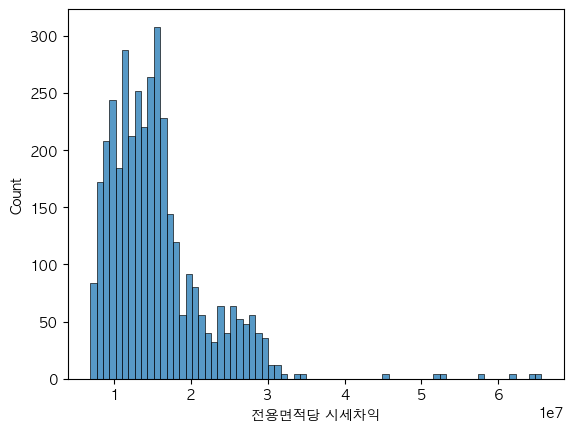

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] =False

sns.histplot(df_train_seoul, x='전용면적당 시세차익')